https://medium.com/analytics-vidhya/multi-class-image-classification-using-transfer-learning-with-deep-convolutional-neural-networks-eab051cde3fb

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

In [65]:
train_DIR = "DATASETJPG _SPLIT/train/"
train_datagen = ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_DIR,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

test_DIR = "DATASETJPG _SPLIT/test/"
validation_datagen = ImageDataGenerator(rescale = 1.0/255) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(test_DIR, shuffle=True, batch_size=32, class_mode='categorical', target_size=(150, 150))

Found 400 images belonging to 20 classes.
Found 160 images belonging to 20 classes.


In [66]:
train_datagen

In [67]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'camel': 0, 'classic': 1, 'comma': 2, 'deer': 3, 'device0': 4, 'device3': 5, 'device4': 6, 'device8': 7, 'dog': 8, 'face': 9, 'fish': 10, 'flatfish': 11, 'fountain': 12, 'frog': 13, 'guitar': 14, 'hammer': 15, 'hat': 16, 'horse': 17, 'horseshoe': 18, 'phone': 19}
{0: 'camel', 1: 'classic', 2: 'comma', 3: 'deer', 4: 'device0', 5: 'device3', 6: 'device4', 7: 'device8', 8: 'dog', 9: 'face', 10: 'fish', 11: 'flatfish', 12: 'fountain', 13: 'frog', 14: 'guitar', 15: 'hammer', 16: 'hat', 17: 'horse', 18: 'horseshoe', 19: 'phone'}


### Displaying images

In [68]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_DIR)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_DIR)):
        image_ids = os.listdir(os.path.join(train_DIR,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            
            display = plt.imread(os.path.join(train_DIR,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

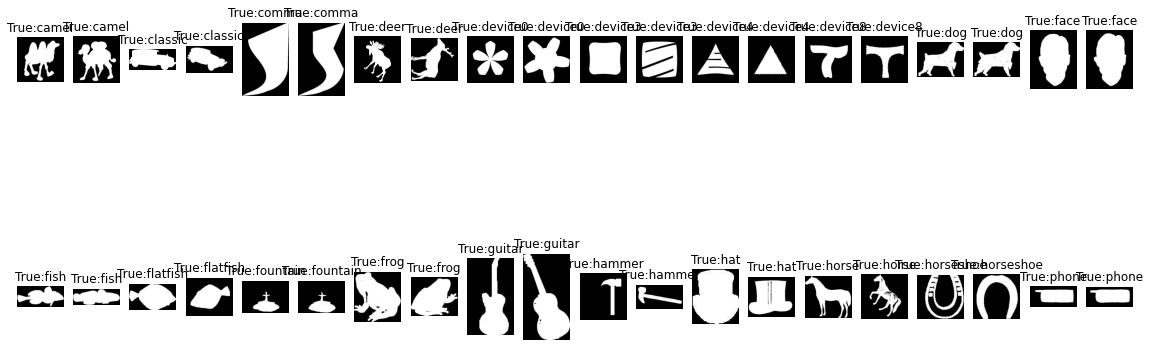

In [69]:
show_few_images(2)

In [71]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [72]:
tf.keras.backend.clear_session()

# epoch config
benchmark_epoch = 10
vgg_epoch = 10
resnet_epoch = 10
inception_epoch = 10

In [76]:
#random architecture
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu', name = 'fc1'))
benchmark_model.add(Dense(20,activation='softmax', name = 'fc2'))

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 144, 144, 128)     18944     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 71, 71, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 67, 67, 64)        204864    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               8388736   
_________________________________________________________________
fc2 (Dense)                  (None, 20)               

In [75]:
filepath = "bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = benchmark_model.fit(train_generator,epochs=benchmark_epoch, verbose=1, validation_data = validation_generator,callbacks=[reduce_lr,early_stopping,checkpoint])

benchmark_model.save(filepath)
do_history_stuff(history, 'benchmark_model')

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 2.8689 - acc: 0.3350

InvalidArgumentError:  Input to reshape is a tensor with 2367488 values, but the requested shape requires a multiple of 173056
	 [[node sequential_1/flatten/Reshape (defined at <ipython-input-75-3b55f94c3627>:5) ]] [Op:__inference_test_function_42937]

Function call stack:
test_function


In [34]:
from keras.models import load_model


In [60]:
new_model = load_model('bench_mark_-model-02-0.96.hdf5')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 144, 128)     18944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 67, 67, 64)        204864    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 128)               8388736   
_________________________________________________________________
fc2 (Dense)                  (None, 20)                2

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


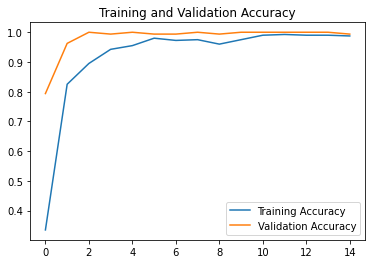

<Figure size 432x288 with 0 Axes>

C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


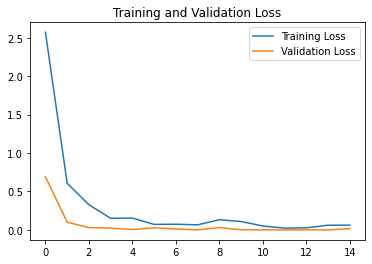

<Figure size 432x288 with 0 Axes>

In [61]:
do_history_stuff(history, 'new_model')

In [62]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
#combined_model_pred = []
#vgg_pred = []
#resnet_pred = []
#inception_pred = []
benchmark_model_pred = []
for folder in os.listdir(test_DIR):
    
    test_image_ids = os.listdir(os.path.join(test_DIR,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(test_DIR,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        img_normalized = img/255
        #vgg
        #vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        #vgg_pred.append(vgg16_image_prediction)
        
        #resnet50
        #resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        #resnet_pred.append(resnet_50_image_prediction)
        
        #Inception
        #inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        #inception_pred.append(inception_image_prediction)
        
        #benchmark
        benchmark_model_prediction = np.argmax(benchmark_model.predict(np.array([img_normalized])))
        benchmark_model_pred.append(benchmark_model_prediction)
        
        #giving vgg16 high priority if they all predict something different
        #image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])                                  
        #combined_model_pred.append(image_prediction)

In [63]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.99375
              precision    recall  f1-score   support

       camel       1.00      1.00      1.00         8
     classic       1.00      1.00      1.00         8
       comma       1.00      1.00      1.00         8
        deer       1.00      1.00      1.00         8
     device0       1.00      1.00      1.00         8
     device3       0.89      1.00      0.94         8
     device4       1.00      1.00      1.00         8
     device8       1.00      1.00      1.00         8
         dog       1.00      1.00      1.00         8
        face       1.00      1.00      1.00         8
        fish       1.00      1.00      1.00         8
    flatfish       1.00      1.00      1.00         8
    fountain       1.00      1.00      1.00         8
        frog       1.00      1.00      1.00         8
      guitar       1.00      1.00      1.00         8
      hammer       1.00      1.00      1.00         8
         hat       1.00      1.00      1.00         8
    

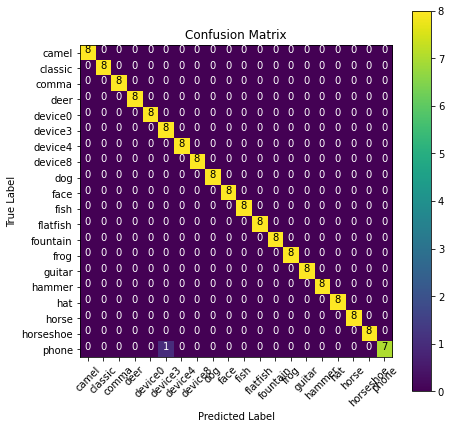

In [64]:
#benchmark model
clf_report(true_value, benchmark_model_pred)

In [77]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall
# setup plot details
colors = cycle(['camel', 'classic', 'comma', 'deer', 'device0', 'device3','device4','device8','dog', 'face', 'fish', 'flatfish',
          'fountain', 'frog', 'guitar', 'hammer', 'hat', 'horse', 'horseshoe', 'phone'])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

ImportError: cannot import name 'recall' from 'sklearn.metrics' (C:\Anaconda\lib\site-packages\sklearn\metrics\__init__.py)